### 価格データを取得して損益を計算する

In [1]:
# データ取得にyfinanceを利用する
# %pip install -U yfinance -q

In [2]:
from time import sleep

import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
start = '2022-01-01'
end = pd.Timestamp.today().date()
index = pd.date_range(start, end, freq='M')  # 月末の日付
symbols = {
            'S&P500': '^GSPC',
            'GOLD': 'GC=F',
            'USD/JPY': 'JPY=X',
            }  # name: ticker

価格データの取得

In [4]:
dfs = {}
for k, v in symbols.items():
    df = yf.download(tickers=v, start=start, end=end, auto_adjust=True)
    df = df.join(pd.DataFrame(index=index), how='outer')  # 月末の日付がなければ入れる
    df = df.ffill()  # 空白は前日のデータで埋める
    dfs[k] = df
    sleep(1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


取得データの確認

In [5]:
dfs['S&P500']  # UTC?

,Open,High,Low,Close,Volume
2022-01-03,4778.140137,4796.640137,4758.169922,4796.560059,3.831020e+09
2022-01-04,4804.509766,4818.620117,4774.270020,4793.540039,4.683170e+09
2022-01-05,4787.990234,4797.700195,4699.439941,4700.580078,4.887960e+09
2022-01-06,4693.390137,4725.009766,4671.259766,4696.049805,4.295280e+09
2022-01-07,4697.660156,4707.950195,4662.740234,4677.029785,4.181510e+09
...,...,...,...,...,...
2024-02-26,5093.000000,5097.660156,5068.910156,5069.529785,3.683930e+09
2024-02-27,5074.600098,5080.689941,5057.290039,5078.180176,3.925950e+09
2024-02-28,5067.200195,5077.370117,5058.350098,5069.759766,3.789370e+09
2024-02-29,5085.359863,5104.990234,5061.890137,5096.270020,5.219740e+09


グラフ表示

In [6]:
def create_axs(nrows, figsize=None):
    _, axs = plt.subplots(nrows, 1, layout='constrained', sharex=True, figsize=figsize)
    params = {'right': True, 'left': False, 'labelleft': False, 'labelright': True}
    for i in range(nrows):
        axs[i].tick_params(**params, bottom=True if i == nrows -1 else False)
        axs[i].yaxis.set_label_position('right')
    return axs

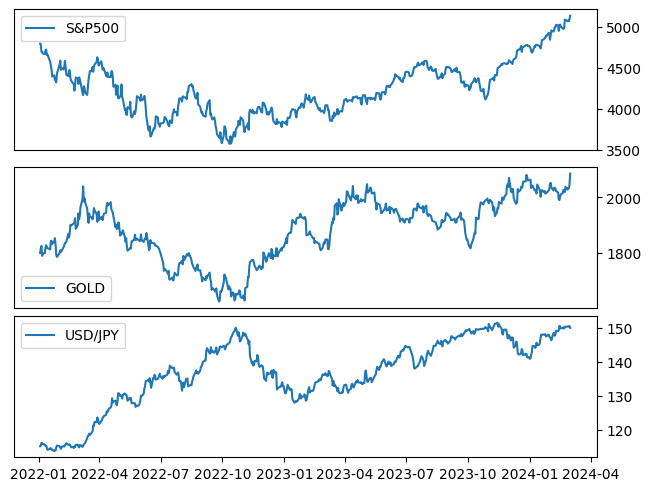

In [7]:
for ax, i in zip(create_axs(3), symbols):
    ax.plot(dfs[i].Close, label=i)
    ax.legend()

使用データ（月末のデータのみを使用）

In [8]:
df = pd.concat([dfs[i].loc[index, ['Close']]['2022-08-01':] for i in symbols], axis=1)
df.columns = symbols
df

,S&P500,GOLD,USD/JPY
2022-08-31,3955.000000,1712.800049,138.733994
2022-09-30,3585.620117,1662.400024,144.431000
2022-10-31,3871.979980,1635.900024,147.811996
2022-11-30,4080.110107,1746.000000,138.744995
2022-12-31,3839.500000,1819.699951,132.916000
2023-01-31,4076.600098,1929.500000,130.479004
2023-02-28,3970.149902,1828.900024,136.317001
2023-03-31,4109.310059,1969.000000,133.201004
2023-04-30,4169.479980,1990.099976,133.802002
2023-05-31,4179.830078,1963.900024,139.792007


購入量の計算（毎月1万円分ずつ購入）

In [9]:
df['YEN_amount'] = 10000  # 毎月の投資資金
df['USD_amount'] = df['YEN_amount'] / df['USD/JPY']  # 両替した時のUSDの量
df['average_USD/JPY'] = (df['USD/JPY'] * df['USD_amount']).cumsum() / df['USD_amount'].cumsum()  # 平均取得単価

for i in ['S&P500', 'GOLD']:
    df[i+'_amount'] = df['USD_amount'] / df[i]  # 購入量
    df[i+'_sum'] = df[i+'_amount'].cumsum()     # 保有量
    df['average_'+i] = (df[i] * df[i+'_amount']).cumsum() / df[i+'_sum']  # 平均取得単価

df.round(4)

,S&P500,GOLD,USD/JPY,YEN_amount,USD_amount,average_USD/JPY,S&P500_amount,S&P500_sum,average_S&P500,GOLD_amount,GOLD_sum,average_GOLD
2022-08-31,3955.0000,1712.8000,138.734,10000,72.0804,138.7340,0.0182,0.0182,3955.0000,0.0421,0.0421,1712.8000
2022-09-30,3585.6201,1662.4000,144.431,10000,69.2372,141.5252,0.0193,0.0375,3764.9735,0.0416,0.0837,1687.7308
2022-10-31,3871.9800,1635.9000,147.812,10000,67.6535,143.5605,0.0175,0.0550,3798.9631,0.0414,0.1251,1670.5949
2022-11-30,4080.1101,1746.0000,138.745,10000,72.0747,142.3256,0.0177,0.0727,3867.3032,0.0413,0.1664,1689.3048
2022-12-31,3839.5000,1819.7000,132.916,10000,75.2355,140.3386,0.0196,0.0923,3861.3985,0.0413,0.2077,1715.2598
2023-01-31,4076.6001,1929.5000,130.479,10000,76.6407,138.5931,0.0188,0.1111,3897.8252,0.0397,0.2474,1749.6518
2023-02-28,3970.1499,1828.9000,136.317,10000,73.3584,138.2633,0.0185,0.1295,3908.1411,0.0401,0.2875,1760.7065
2023-03-31,4109.3101,1969.0000,133.201,10000,75.0745,137.6096,0.0183,0.1478,3933.0049,0.0381,0.3257,1785.0925
2023-04-30,4169.4800,1990.1000,133.802,10000,74.7373,137.1758,0.0179,0.1657,3958.5799,0.0376,0.3632,1806.2886
2023-05-31,4179.8301,1963.9000,139.792,10000,71.5348,137.4330,0.0171,0.1829,3979.2880,0.0364,0.3997,1820.6535


損益の計算

In [10]:
profit = pd.DataFrame()

# 評価額
for i in ['S&P500', 'GOLD']:
    profit[i+'_USD'] = df[i] * df[i+'_sum']              # 評価額 = 価格 * 保有量
    profit[i+'_YEN'] = profit[i+'_USD'] * df['USD/JPY']  # 評価額を円換算

for i in ['USD', 'YEN']:
    profit['Sum_'+i] = profit['S&P500_'+i] + profit['GOLD_'+i]  # S&P500とGOLDの評価額の合計

# 収益
for i in ['S&P500', 'GOLD', 'Sum']:
    YEN_sum = df['YEN_amount'].cumsum() * (1 if i != 'Sum' else 2)  # 投資額
    profit[i+'_pnl[%]'] = 100 * (profit[i+'_YEN'] / YEN_sum - 1)    # 収益率 = 評価額 / 投資額
    profit[i+'_pnl[YEN]'] = profit[i+'_YEN'] - YEN_sum              # 収益額 = 評価額 - 投資額

profit.round(2)

,S&P500_USD,S&P500_YEN,GOLD_USD,GOLD_YEN,Sum_USD,Sum_YEN,S&P500_pnl[%],S&P500_pnl[YEN],GOLD_pnl[%],GOLD_pnl[YEN],Sum_pnl[%],Sum_pnl[YEN]
2022-08-31,72.08,10000.00,72.08,10000.00,144.16,20000.00,0.00,0.00,0.00,0.00,0.00,0.00
2022-09-30,134.59,19438.33,139.20,20104.30,273.78,39542.64,-2.81,-561.67,0.52,104.30,-1.14,-457.36
2022-10-31,212.99,31482.12,204.63,30246.95,417.62,61729.07,4.94,1482.12,0.82,246.95,2.88,1729.07
2022-11-30,296.51,41139.41,290.48,40302.37,586.99,81441.78,2.85,1139.41,0.76,302.37,1.80,1441.78
2022-12-31,354.26,47086.92,377.97,50238.90,732.24,97325.82,-5.83,-2913.08,0.48,238.90,-2.67,-2674.18
2023-01-31,452.78,59078.03,477.42,62293.60,930.20,121371.62,-1.54,-921.97,3.82,2293.60,1.14,1371.62
2023-02-28,514.31,70109.65,525.89,71687.61,1040.20,141797.26,0.16,109.65,2.41,1687.61,1.28,1797.26
2023-03-31,607.42,80908.33,641.25,85414.93,1248.66,166323.26,1.14,908.33,6.77,5414.93,3.95,6323.26
2023-04-30,691.05,92463.42,722.86,96719.77,1413.90,189183.18,2.74,2463.42,7.47,6719.77,5.10,9183.18
2023-05-31,764.30,106842.59,784.88,109719.35,1549.17,216561.95,6.84,6842.59,9.72,9719.35,8.28,16561.95


損益グラフ

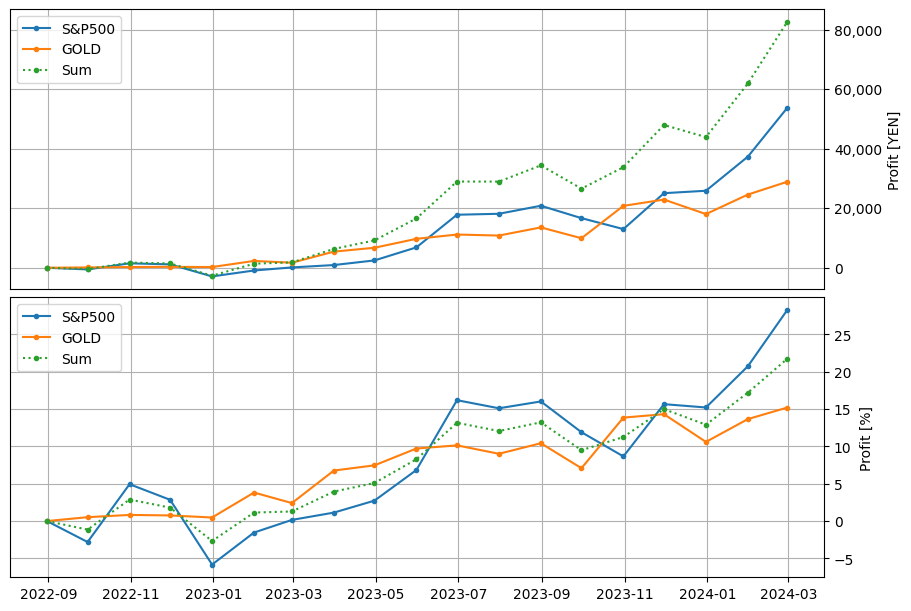

In [11]:
ax1, ax2 = create_axs(2, [9, 6])
for i in ['S&P500', 'GOLD', 'Sum']:
    linestyle = ':' if i == 'Sum' else None
    ax1.plot(profit[i+'_pnl[YEN]'], label=i, marker='.', linestyle=linestyle)
    ax2.plot(profit[i+'_pnl[%]'], label=i, marker='.', linestyle=linestyle)

ax1.set_ylabel('Profit [YEN]')
ax2.set_ylabel('Profit [%]')
ax1.yaxis.set_major_formatter(lambda x, _: f'{x:,.0f}')
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

価格グラフ（平均取得単価）

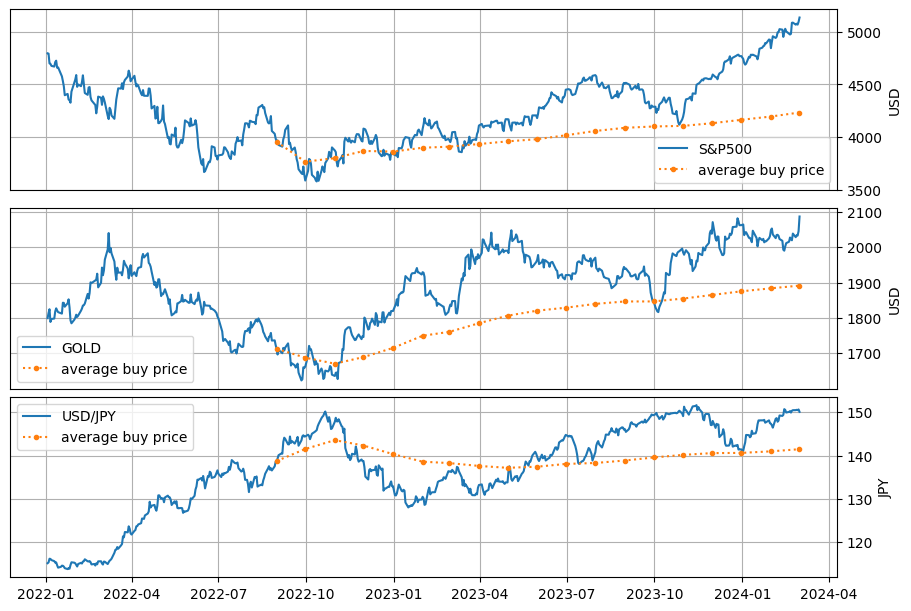

In [12]:
for ax, i, j in zip(create_axs(3, [9, 6]), symbols, ['USD', 'USD', 'JPY']):
    ax.plot(dfs[i].Close, label=i)
    ax.plot(df['average_'+i], label='average buy price', marker='.', linestyle=':')
    ax.set_ylabel(j)
    ax.legend()
    ax.grid()